In [110]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [111]:
import os
import pandas as pd
%pylab inline

data_2015 = pd.read_csv('2015-building-energy-benchmarking_selected.csv', sep=',', index_col=[0])
data_2016 = pd.read_csv('2016-building-energy-benchmarking_selected.csv', sep=',', index_col=[0])

Populating the interactive namespace from numpy and matplotlib


In [112]:
id_col = ['PropertyName']

des_col = ['CouncilDistrictCode','LargestPropertyUseType','BuildingType',
           'Neighborhood','SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
           'PrimaryPropertyType']

q_col = ['YearBuilt', 'PropertyGFATotal', 
         'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 
         'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 
        ]

y_col = ['SiteEnergyUseWN(kBtu)']

es_col = ['ENERGYSTARScore']

# Step before regression

## Expand categorical columns

In [113]:
## Expand categorical columns
new_col_2015 = set()
for col in des_col:
    dataframe = pd.get_dummies(data_2015[col],prefix=col)
    new_col_2015.update(dataframe.columns)
    data_2015 = data_2015.join(dataframe)
    data_2015.drop(col, axis=1, inplace=True)

new_col_2016 = set()
for col in des_col:
    dataframe = pd.get_dummies(data_2016[col],prefix=col)
    new_col_2016.update(dataframe.columns)
    data_2016 = data_2016.join(dataframe)
    data_2016.drop(col, axis=1, inplace=True)
    
new_col = new_col_2015.union(new_col_2016)
print('created columns number:', len(new_col))

created columns number: 217


In [114]:
data = pd.concat([data_2015, data_2016], axis=0)
data.fillna(0, inplace=True)

In [115]:
data_2015_cut = data_2015[data_2015["SiteEnergyUseWN(kBtu)"]<5e7]

# Define some function for regression model comparaison

## Regression models creation

In [116]:
from sklearn import neighbors
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor    
from sklearn.ensemble import GradientBoostingRegressor

# Ridge model
ridge_model = Ridge(alpha=1e3)
# Lasso model
lasso_model = Lasso(alpha=1e6)
# ElasticNet model
elasticNet_model = ElasticNet(alpha=1, l1_ratio=0.4)
# SVR model
SVR_model = SVR(max_iter=10000, C=2e4,  kernel='linear')
# Linear SVR model
linearSVR_model = LinearSVR(C=1e-3, 
                            epsilon=1e2, 
                            loss='squared_epsilon_insensitive')

# Kernel Ridge model
kernelRidge_model = KernelRidge(alpha=2, degree=2, kernel='poly')
# Bagging Regressor
bagging_model = BaggingRegressor(base_estimator=Ridge(alpha=1e3), \
                 n_estimators=100, 
                 n_jobs=-1)
# Random Forest model
randomForest_model = RandomForestRegressor(random_state=0, 
                                           n_jobs=-1, 
                                           max_depth=1000,
                                           min_samples_split=10e-5,
                                           min_samples_leaf=10e-4,
                                           min_weight_fraction_leaf=10e-4,
                                           max_features='sqrt',
                                           ccp_alpha=1,
                                           max_samples=0.99)
# Gradient Boost model
gradientBoost_model = GradientBoostingRegressor(random_state=0,
                                                alpha=0.8, 
                                                loss='huber', 
                                                max_features='sqrt')

models_list = {'Ridge':ridge_model, 'Lasso':lasso_model, 'ElasticNet':elasticNet_model, 
               'SVR': SVR_model, 'LinearSVR':linearSVR_model, 
               'KernelRidge':kernelRidge_model, 'Bagging':bagging_model, 'RandomForest':randomForest_model, 
               'GradientBoost':gradientBoost_model}

## Apply cross validation function implementation

In [117]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

def indirect(scorer, y_test, y_pred):
    switcher = {
        'explained_variance': metrics.explained_variance_score,
        'max_error': metrics.max_error,
        'neg_mean_absolute_error': metrics.mean_absolute_error,
        'neg_mean_squared_error': metrics.mean_squared_error,
        'neg_mean_squared_log_error': metrics.mean_squared_log_error,
        'neg_median_absolute_error': metrics.median_absolute_error,
        'r2': metrics.r2_score,
        'neg_mean_absolute_percentage_error': metrics.mean_absolute_percentage_error,
    } 
    func = switcher.get(scorer, lambda:"nothing")
    return func(y_test, y_pred)

def apply_cv(_estimator, _curve, _x_axis, _subset_number, _score_type, _X, _y):
    # Split in train-test data
    X_train, X_test, y_train, y_test = model_selection.train_test_split(_X, 
                                                                        _y, 
                                                                        test_size=0.3)

    # Apply cross validation minimization
    scores = cross_val_score(estimator=_estimator, 
                             X=X_train, 
                             y=y_train.values.ravel(), 
                             cv=_subset_number, 
                             scoring=_score_type)
    # Fit train data with estimator
    estimator = _estimator.fit(X_train, y_train.values.ravel())
        
    # Predict on test data
    y_pred = estimator.predict(X_test) 
    
    print(_estimator, ' '+_score_type+': error_test', indirect(_score_type, y_test, y_pred))
    print(_estimator, ' '+_score_type+': error_mean', np.mean(scores))
    
    # Save results in a dataframe
    scores_df = pd.DataFrame()
    if _score_type in ['neg_mean_absolute_error', 'neg_mean_squared_error',
                       'neg_median_absolute_error']:
        scores_df.loc[0, 'score_test'] = -indirect(_score_type, y_test, y_pred)
    else:
        scores_df.loc[0, 'score_test'] = indirect(_score_type, y_test, y_pred)
    scores_df.loc[0, 'score_var'] = np.std(scores)
    scores_df.loc[0, 'score_mean'] = np.mean(scores)
    scores_df.loc[0, 'curve'] = _curve
    scores_df.loc[0, 'x_axis'] = _x_axis
    return scores_df

## Implement visualization function

In [124]:
import colorsys
import seaborn as sns
sns.set(style="darkgrid")
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def get_colors(_n):
    HSV_tuples = [(x*1.0/_n, 0.5, 0.5) for x in range(_n)]
    return [colorsys.hsv_to_rgb(hsv_col[0], hsv_col[1], hsv_col[2]) for hsv_col in HSV_tuples]

def visualize_scores_mean(_scores_df, _title, _with_std=True, _with_test_score=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))

    # Get out if more than one curve
    if len(_scores_df['curve'].unique()) > 1:
        print("can not plot scores mean")
        return ax
    # Plot curve
    plt.plot(_scores_df['x_axis'], _scores_df['score_mean'], color='b')
    
    # Create legend text
    legend_elements=[]
    legend_elements.append(Line2D([0], [0], color='b', lw=4, label="train set score mean"))

    # Add test score points
    if _with_test_score:
        plt.scatter(_scores_df['x_axis'], _scores_df['score_test'], color='g', s=20*2**2)
        legend_elements.append(Line2D([0], [0], marker='o', color='g', label="test set scores",
                              markerfacecolor='g', markersize=15))
        
    if _with_std:
        y_low = (_scores_df['score_mean']-_scores_df['score_var']).to_list()
        y_sup = (_scores_df['score_mean']+_scores_df['score_var']).to_list()
        plt.vlines(_scores_df['x_axis'], y_low, y_sup, color='b')
        ind = np.arange(len(_scores_df['x_axis']))
        x_low = ind - 0.05
        x_sup = ind + 0.05
        plt.hlines(y_low, x_low, x_sup, color='b')
        plt.hlines(y_sup, x_low, x_sup, color='b')

    # plot legend
    ax.legend(handles=legend_elements, fontsize=18)
    
    if (_scores_df['score_mean'].max() + _scores_df['score_var'].max()) - \
       (_scores_df['score_mean'].min() - _scores_df['score_var'].min()) < 1.4:
        ax.set_yticks(np.arange(0, 1, 0.2).tolist())
    
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20,rotation=0)

    plt.ylabel('Score', fontsize=25)
    
    # Add title
    plt.title(_title, fontsize=25)
    
    return ax

def visualize_test_scores(_scores_df, _title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))

    curves = list(_scores_df['curve'].unique())
    curve_colors = get_colors(len(curves))
    
    patches=[]
    for curve, color in zip(curves, curve_colors):
        curve_df = _scores_df[_scores_df['curve'] == curve]
        plt.plot(curve_df['x_axis'], curve_df['score_test'], color=color)
        plt.scatter(curve_df['x_axis'], curve_df['score_test'], color=color)
        
        patches.append(Patch(label=curve, fill=True, color=color))
    
    if (_scores_df['score_test'].max()) - (_scores_df['score_test'].min()) < 1.4:
        ax.set_yticks(np.arange(0, 1, 0.2).tolist())
    
    ax.legend(handles=patches, fontsize=18)

    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20,rotation=0)

    plt.ylabel('Score', fontsize=25)
    
    # Add title
    plt.title(_title, fontsize=25)
    
    return ax

# Define some function for regression model comparaison

## Models comparaison on 2015 data

In [119]:
from sklearn.preprocessing import StandardScaler

# Get X
X = data_2015[q_col+list(new_col_2015)]
std_scale = StandardScaler().fit(X)
X_std = std_scale.transform(X)

# Get y
y = data_2015['SiteEnergyUseWN(kBtu)']

regression model : Ridge
Ridge(alpha=1000.0)  r2: error_test 0.6525733330711185
Ridge(alpha=1000.0)  r2: error_mean 0.4956951858548041
regression model : Lasso
Lasso(alpha=1000000.0)  r2: error_test 0.5568436551361828
Lasso(alpha=1000000.0)  r2: error_mean 0.5439048901611143
regression model : ElasticNet
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.359354416436499
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.62969334895117
regression model : SVR


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_test 0.5463278625507241
SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_mean 0.5258705441020844
regression model : LinearSVR
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_test 0.259956866194732
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_mean 0.48991354906242995
regression model : KernelRidge
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_test 0.7720665654495982
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_mean 0.3282109517386967
regression model : Bagging
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  r2: error_test 0.4760052416084527
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  r2: error_mean 0.6118917666792137
regression model : RandomForest
RandomForestRegressor(ccp_alpha=1, max_depth=1000, max_features='sqrt',
   

0

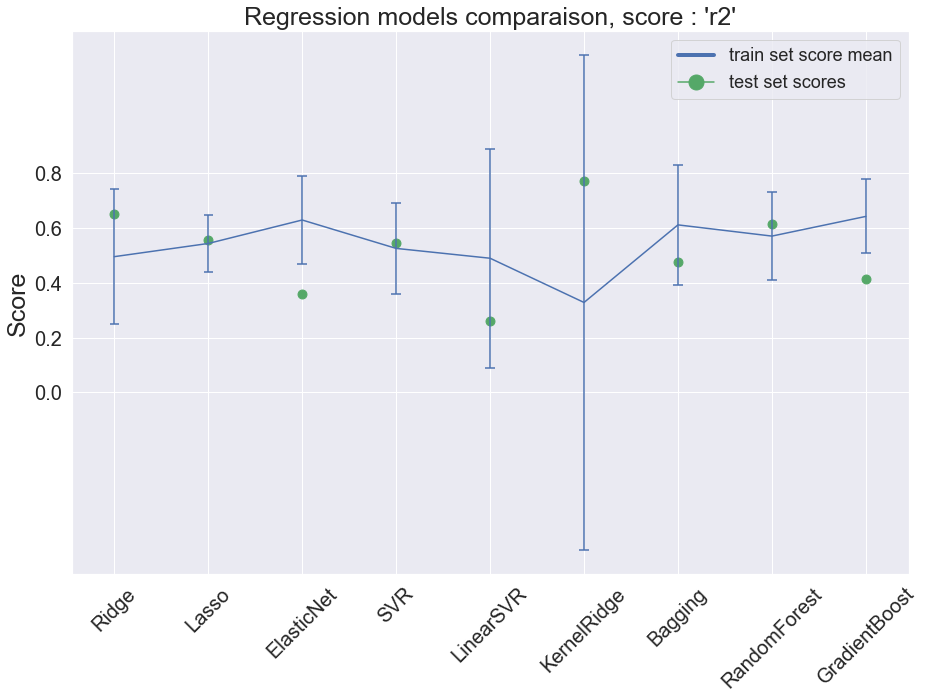

In [120]:
from time import process_time

# Create dataframe to save process time of each regression model
time_df = pd.DataFrame()

# Create subset number
subset_number = 10
# Choose score type
score_type = 'r2'

# Create dataframe that collect score and std score for each regression model
global_scores = pd.DataFrame()

for model in models_list.items():
    t_start = process_time()
    print('regression model :', model[0])
    score_df = apply_cv(model[1], score_type, model[0], subset_number, score_type, X_std,  y)
    global_scores = pd.concat([global_scores, score_df], ignore_index=True)
    t_stop = process_time()
    time_df.loc[0,model[0]] = t_stop-t_start

# Plot results
ax = visualize_scores_mean(global_scores, 
                           "Regression models comparaison, score : '"+score_type+"'",
                           _with_test_score=True)

os.system("printf '\7'")

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_xticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


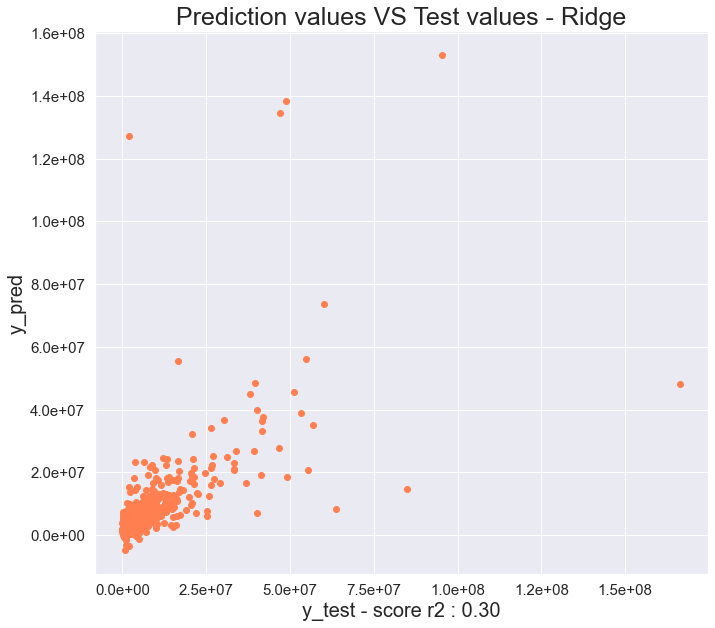

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_xticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


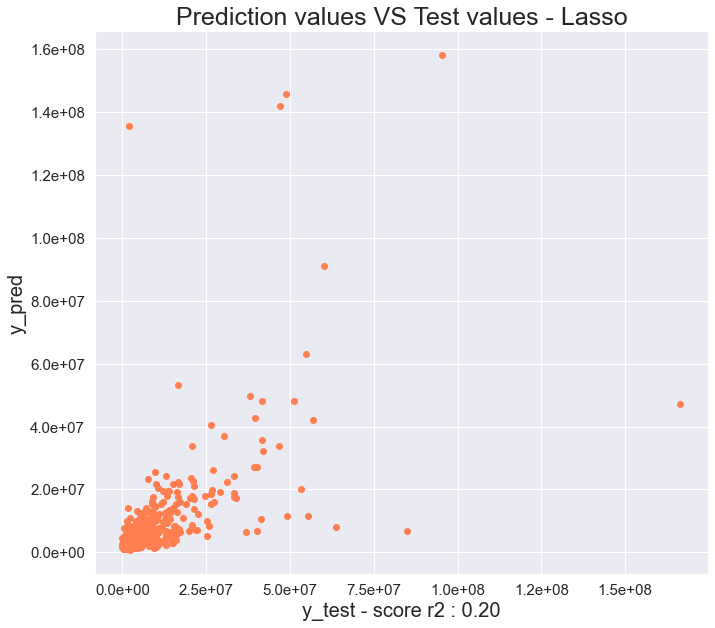

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_xticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


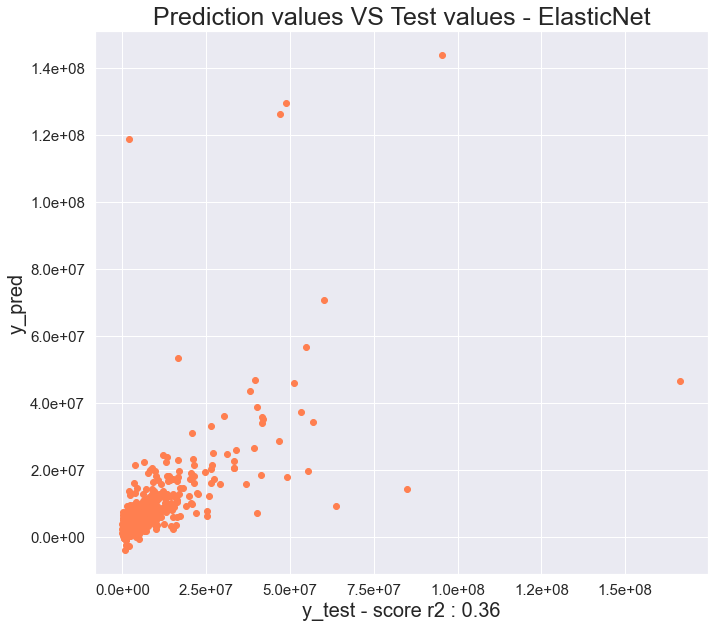

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_xticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


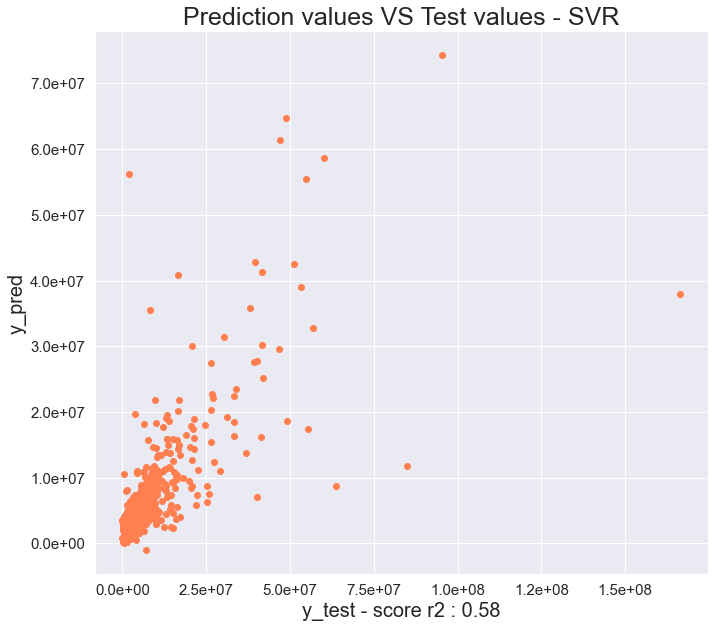

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_xticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


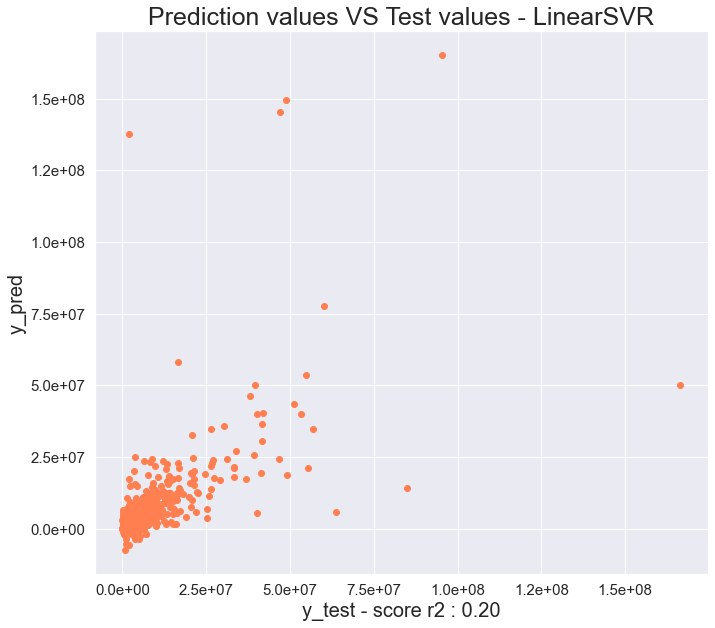

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_xticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


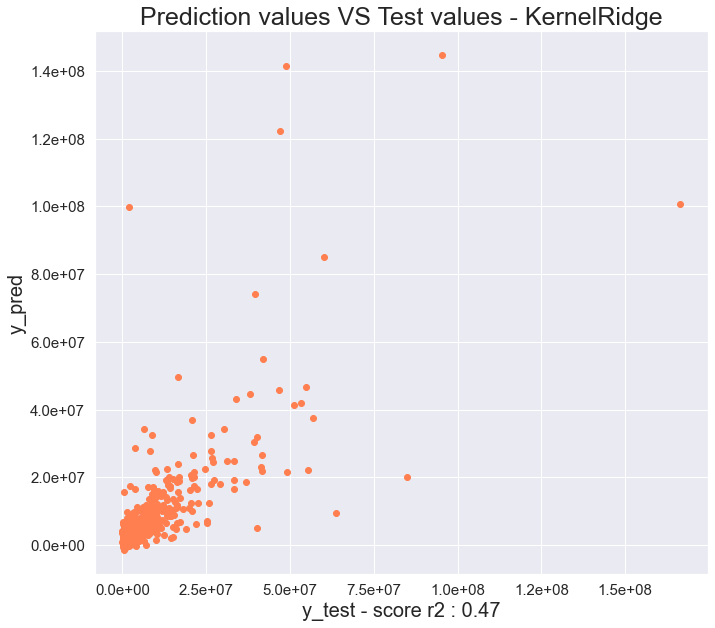

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_xticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


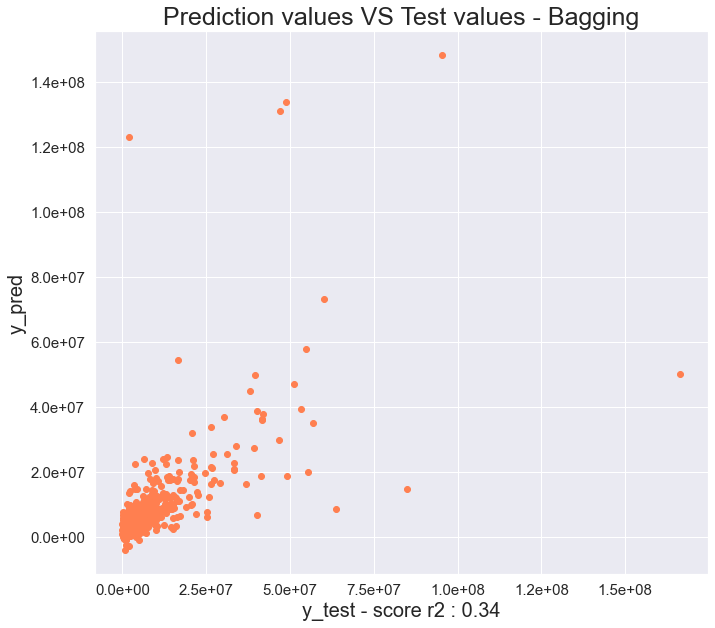

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_xticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


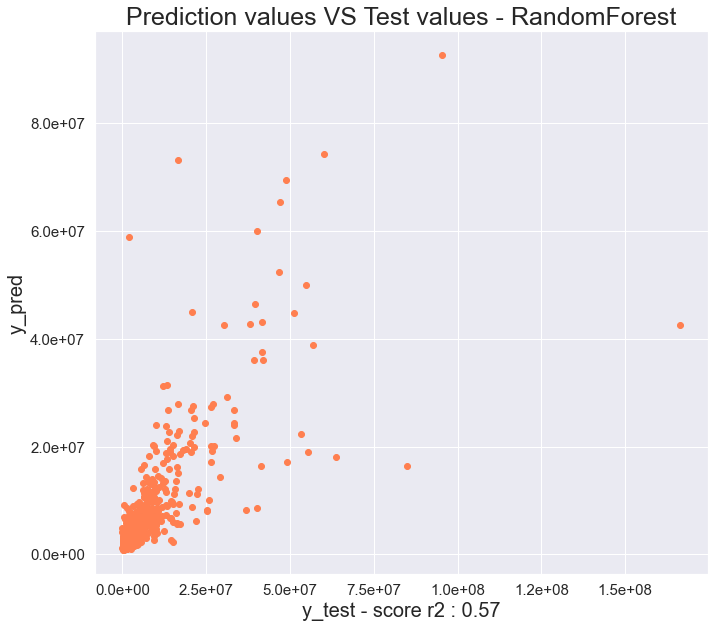

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_xticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/442074566.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


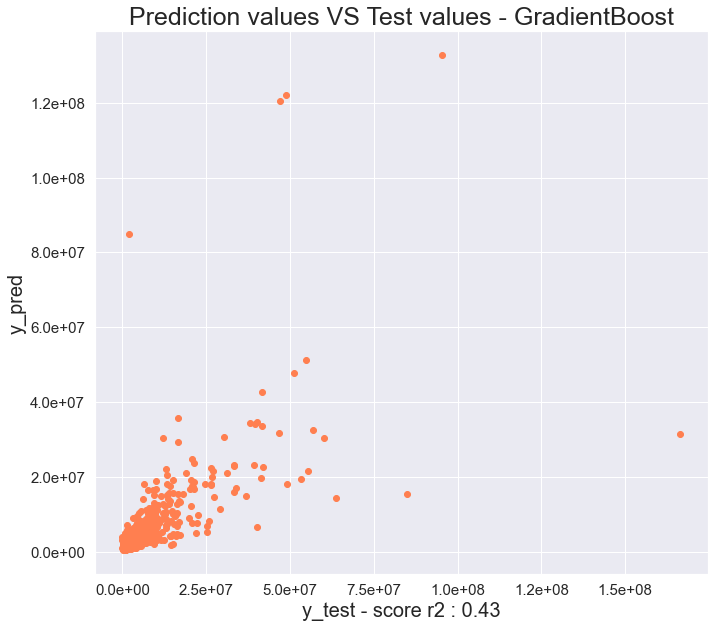

In [121]:
# Split in train-test data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, random_state=100, test_size=0.3)
 
for model in models_list.items():
    # Fit train data with estimator
    model_fit = model[1].fit(X_train, y_train.values.ravel())
        
    # Predict on test data
    y_pred = model_fit.predict(X_test) 
    score = indirect('r2', y_test, y_pred)
    
    # Plot predicted data according to test data 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,10))
    plt.scatter(y_test, y_pred, color='coral')
    plt.xlabel("y_test - score r2 : "+"{0:.2f}".format(score), fontsize=20)
    plt.ylabel("y_pred", fontsize=20)
    ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_xticks()])
    ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.set_title('Prediction values VS Test values - '+model[0], fontsize=25)
    plt.show()

## linear-y VS log-y comparaison

In [122]:
from sklearn.preprocessing import StandardScaler

data_2015_ = data_2015[data_2015['SiteEnergyUseWN(kBtu)']!=0]

# Get X
X = data_2015_[q_col+list(new_col_2015)]
std_scale = StandardScaler().fit(X)
X_std = std_scale.transform(X)

# Get y
y = data_2015_['SiteEnergyUseWN(kBtu)']

regression model : Ridge
Ridge(alpha=1000.0)  r2: error_test 0.5659953912118965
Ridge(alpha=1000.0)  r2: error_mean 0.6384228373218848
Ridge(alpha=1000.0)  r2: error_test 0.6031516386960044
Ridge(alpha=1000.0)  r2: error_mean 0.5716003883539583
regression model : Lasso
Lasso(alpha=1000000.0)  r2: error_test 0.6070376268826954
Lasso(alpha=1000000.0)  r2: error_mean 0.5058539298924101
Lasso(alpha=1000000.0)  r2: error_test -0.0001035242869082964
Lasso(alpha=1000000.0)  r2: error_mean -0.0051313623725423255
regression model : ElasticNet
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.5570263899334121
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.6105601221103667
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.2347048986119108
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.24432548777650256
regression model : SVR


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_test 0.41058750285428625
SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_mean 0.676459381769386


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_test -40.235924655866704
SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_mean -48.90765647120111
regression model : LinearSVR
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_test 0.7134207840082788
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_mean 0.543460597281079
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_test -160.67193816365744
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_mean -170.93524561172222
regression model : KernelRidge
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_test 0.6089156074287565
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_mean 0.6939194800603466
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_test 0.659335001696209
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_mean 0.6601862925801212
regression model : Bagging
Ba

0

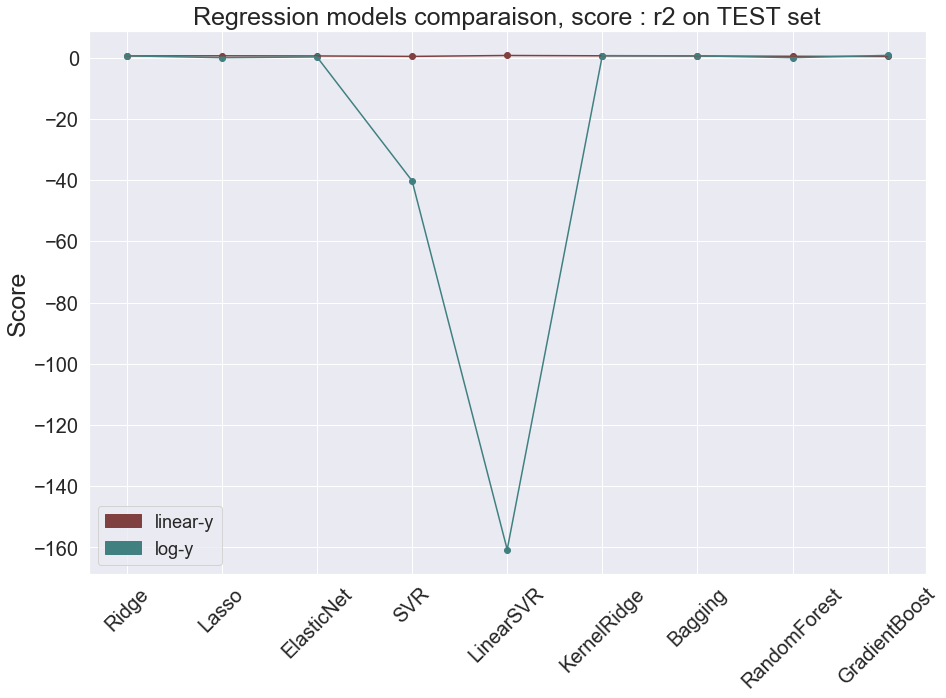

In [125]:
import os

# Create dataframe to save process time of each regression model
time_df = pd.DataFrame()

# Create subset number
subset_number = 10
# Choose score type
score_type = 'r2'

# Create dataframe that collect score and std score for each regression model
global_scores = pd.DataFrame()

for model in models_list.items():
    print('regression model :', model[0])
    score_df = apply_cv(model[1], 'linear-y', model[0], subset_number, score_type, X_std,  y)
    global_scores = pd.concat([global_scores, score_df], ignore_index=True)
    score_df = apply_cv(model[1], 'log-y', model[0], subset_number, score_type, X_std,  log(y))
    global_scores = pd.concat([global_scores, score_df], ignore_index=True) 

# Plot results
ax = visualize_test_scores(global_scores, 
                           "Regression models comparaison, score : "+score_type+" on TEST set")

os.system("printf '\7'")

## linear-y VS log-y comparaison without SVR and LinearSVR

regression model : Ridge
Ridge(alpha=1000.0)  r2: error_test 0.48560067864388745
Ridge(alpha=1000.0)  r2: error_mean 0.6428633008351603
Ridge(alpha=1000.0)  r2: error_test 0.607719482338658
Ridge(alpha=1000.0)  r2: error_mean 0.5668331021045024
regression model : Lasso
Lasso(alpha=1000000.0)  r2: error_test 0.67376163910467
Lasso(alpha=1000000.0)  r2: error_mean 0.38619034895179133
Lasso(alpha=1000000.0)  r2: error_test -0.0012680973775391902
Lasso(alpha=1000000.0)  r2: error_mean -0.0032577304698048425
regression model : ElasticNet
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.5446249441847482
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.6510233647936637
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.2400148802760772
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.21519700582591886
regression model : KernelRidge
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_test 0.654278862976161
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_mean 0.618207003

0

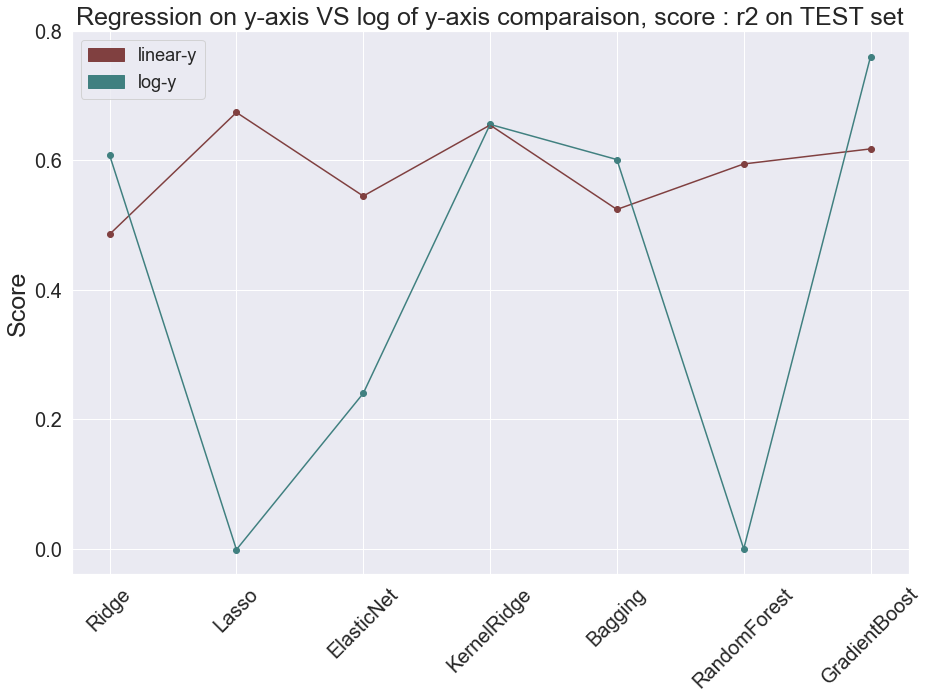

In [126]:
# Create subset number
subset_number = 10
# Choose score type
score_type = 'r2'

# Create dataframe that collect score and std score for each regression model
global_scores = pd.DataFrame()

for model in models_list.items():
    if model[0] == 'SVR' or model[0] == 'LinearSVR':
        continue
    print('regression model :', model[0])
    score_df = apply_cv(model[1], 'linear-y', model[0], subset_number, score_type, X_std,  y)
    global_scores = pd.concat([global_scores, score_df], ignore_index=True)
    score_df = apply_cv(model[1], 'log-y', model[0], subset_number, score_type, X_std,  log(y))
    global_scores = pd.concat([global_scores, score_df], ignore_index=True) 

# Plot results
ax = visualize_test_scores(global_scores,
        "Regression on y-axis VS log of y-axis comparaison, score : "+score_type+" on TEST set")

os.system("printf '\7'")

## Models comparaison on 2015 data filtered

In [127]:
from sklearn.preprocessing import StandardScaler

# Get X
X = data_2015_cut[q_col+list(new_col_2015)]
std_scale = StandardScaler().fit(X)
X_std = std_scale.transform(X)

# Get y
y = data_2015_cut['SiteEnergyUseWN(kBtu)']

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


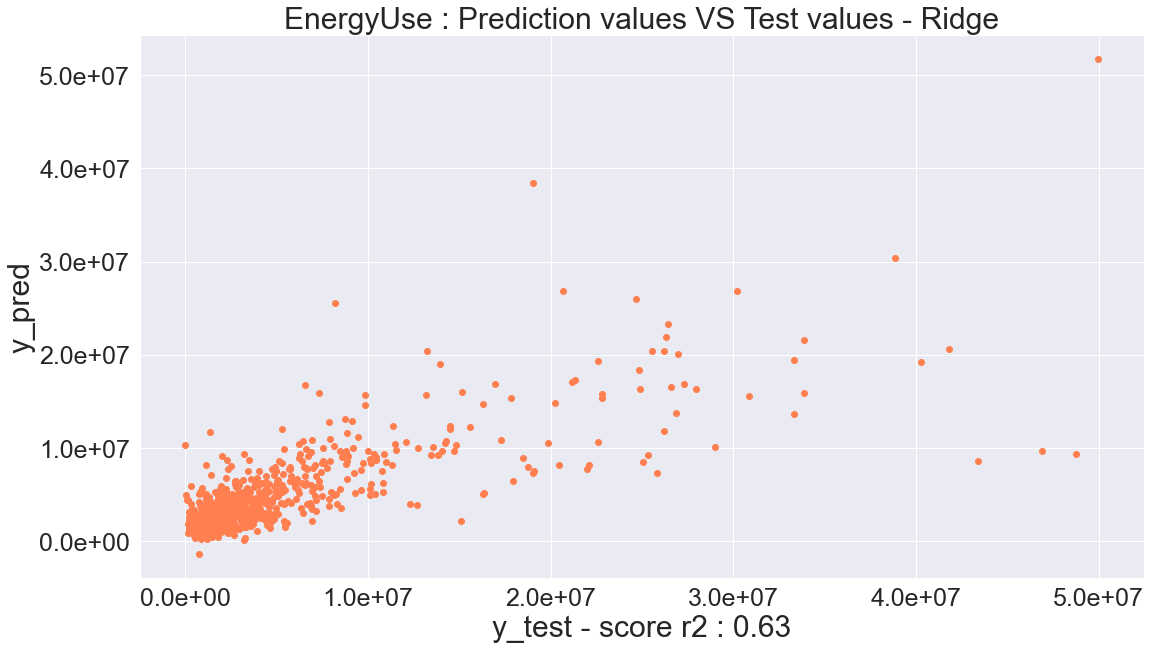

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


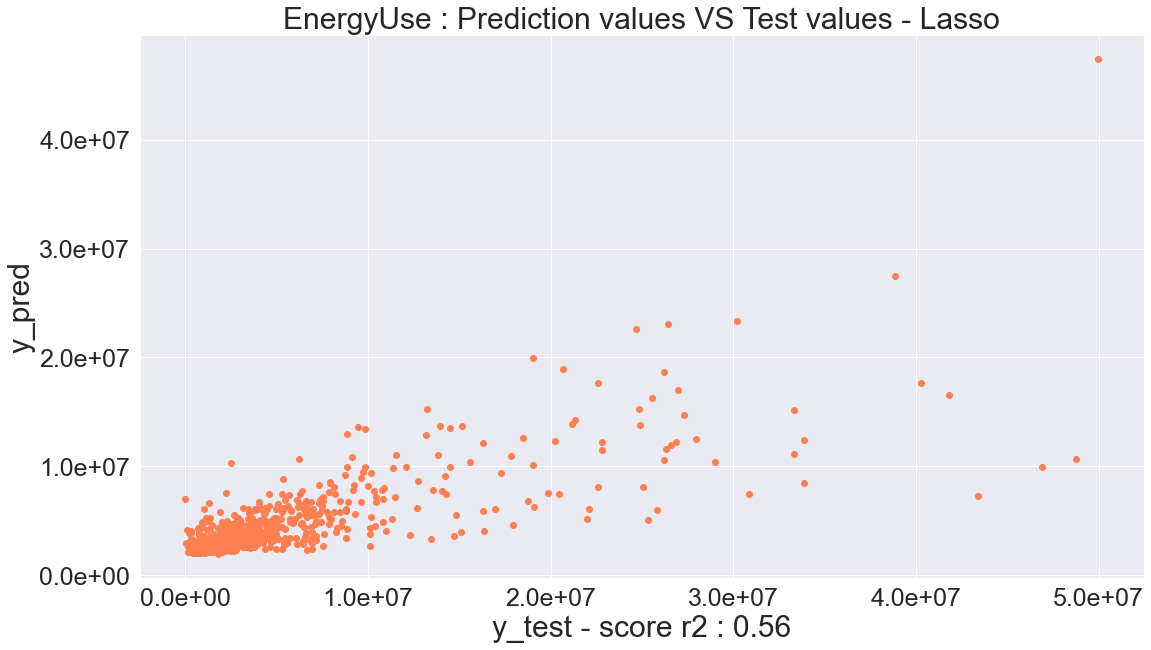

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


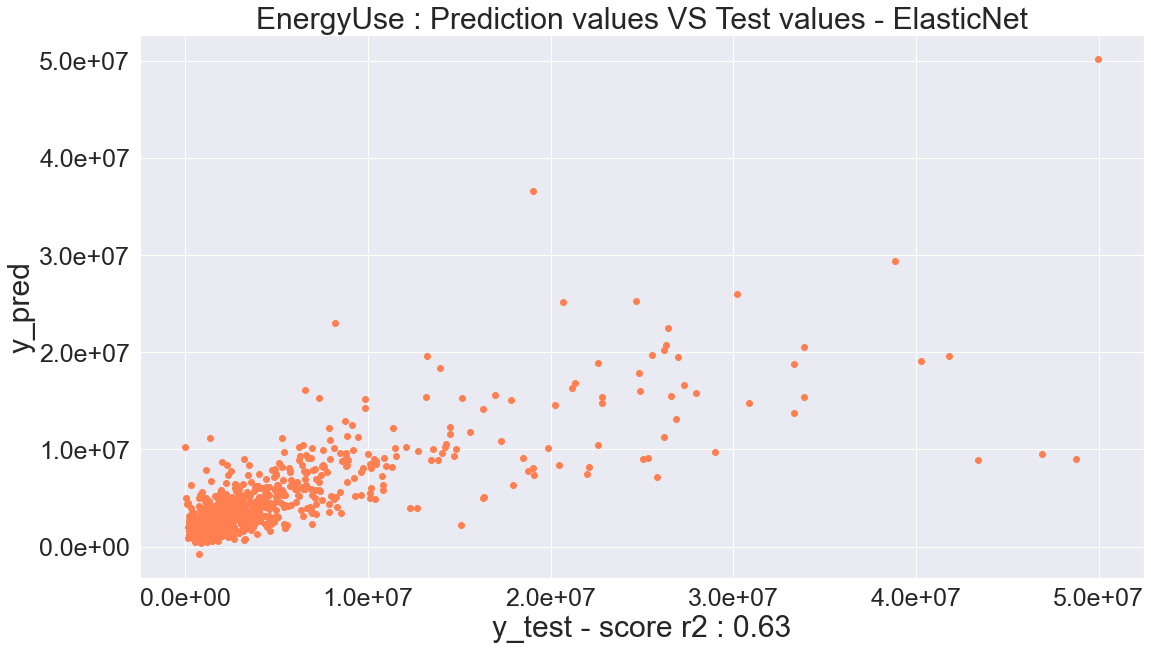

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


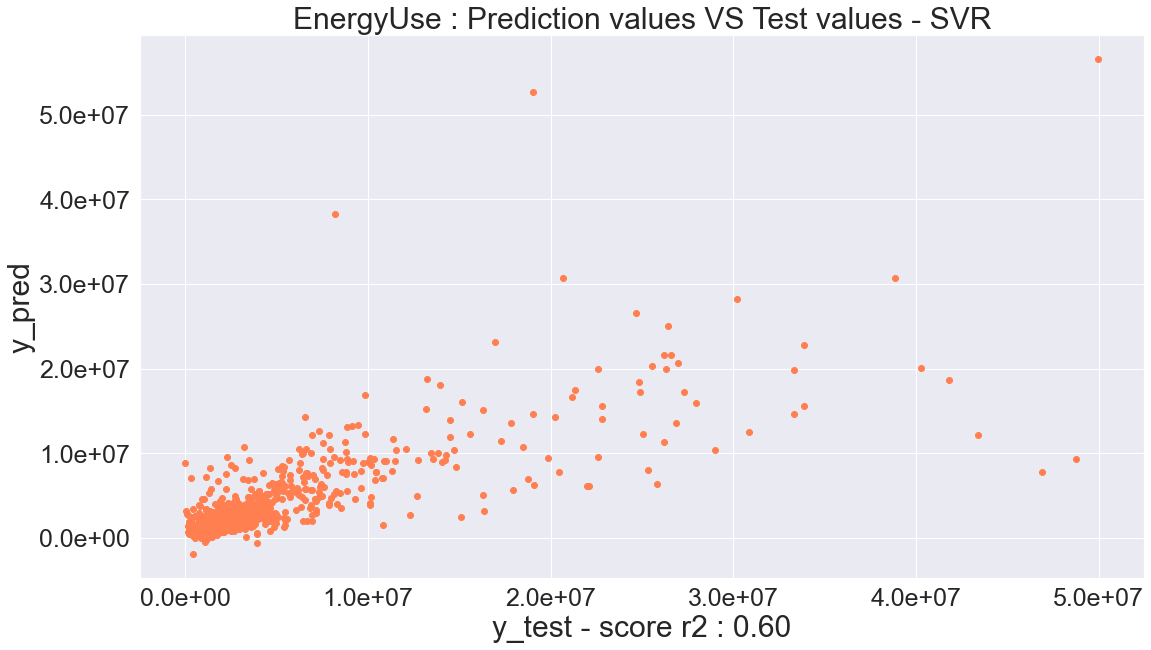

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


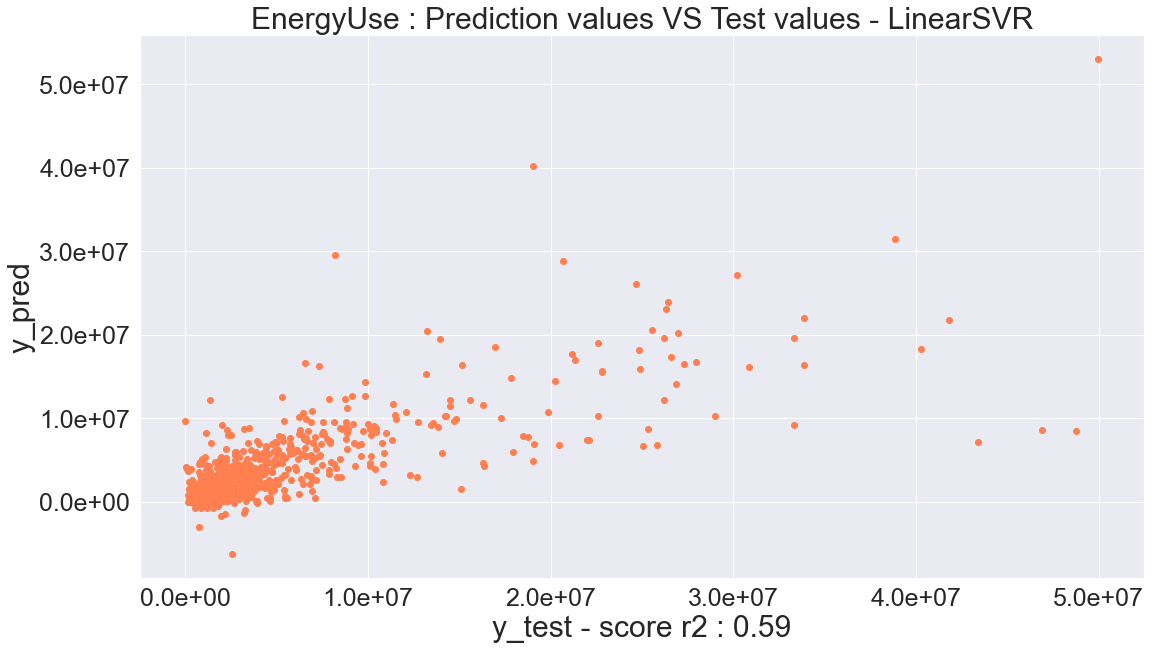

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


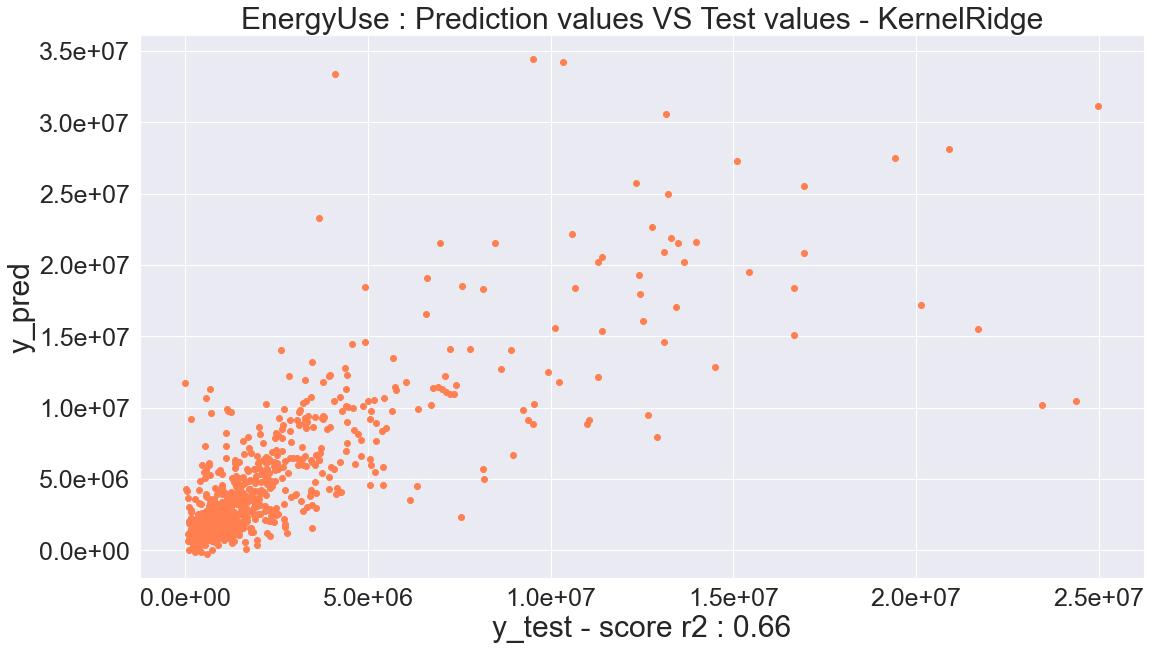

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


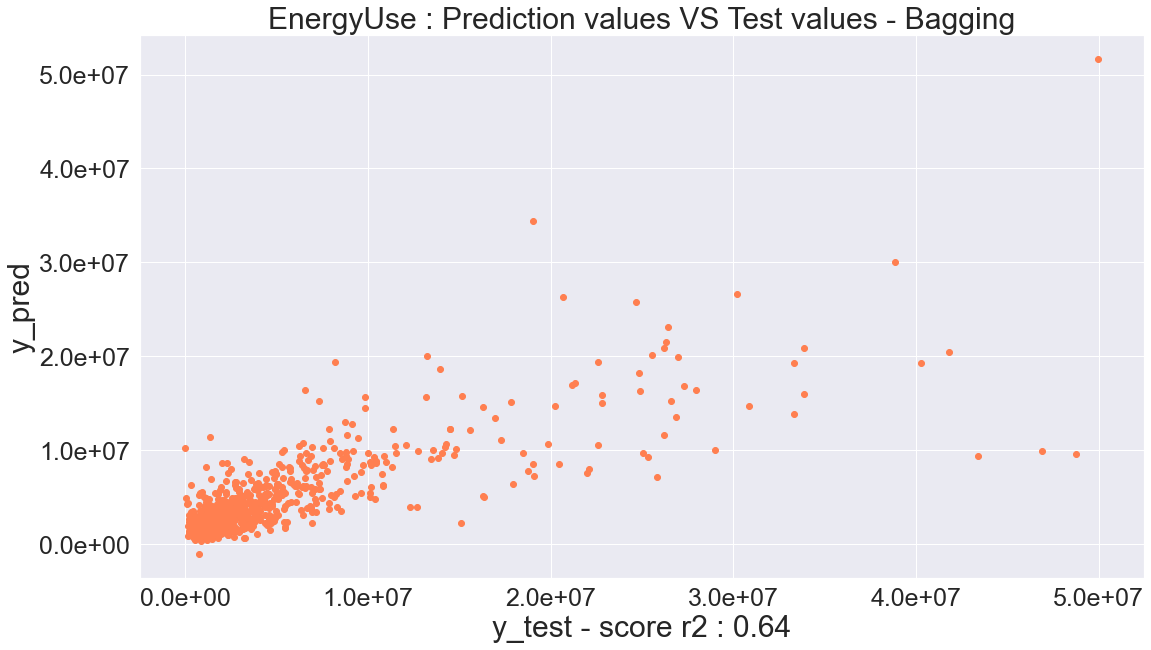

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


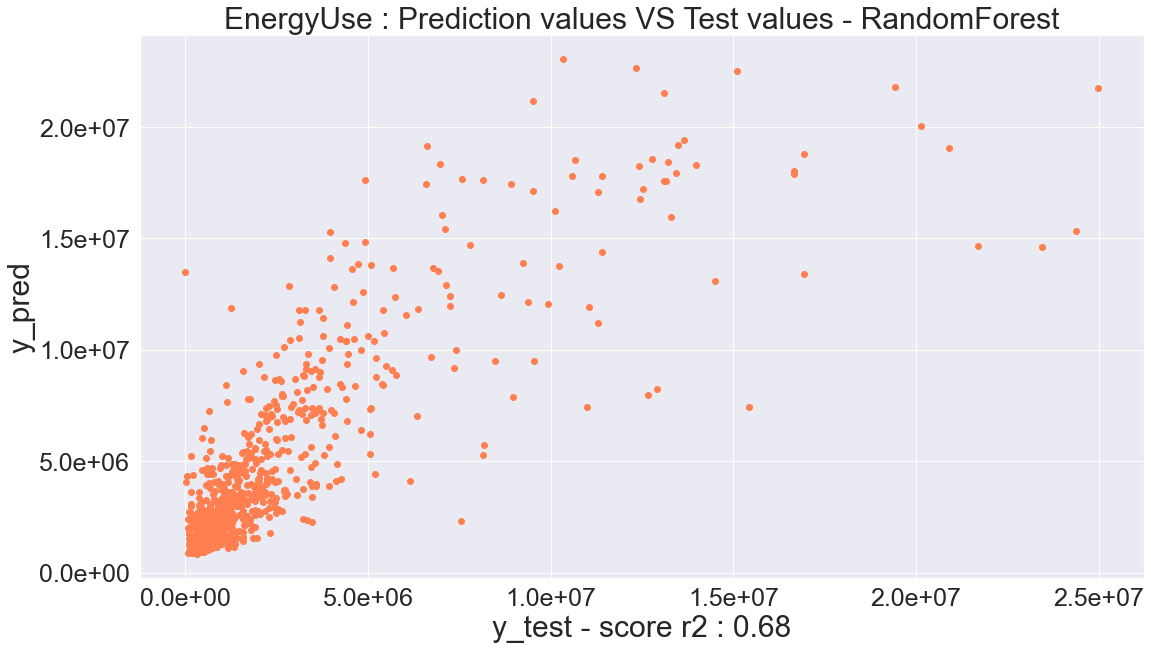

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1355062567.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


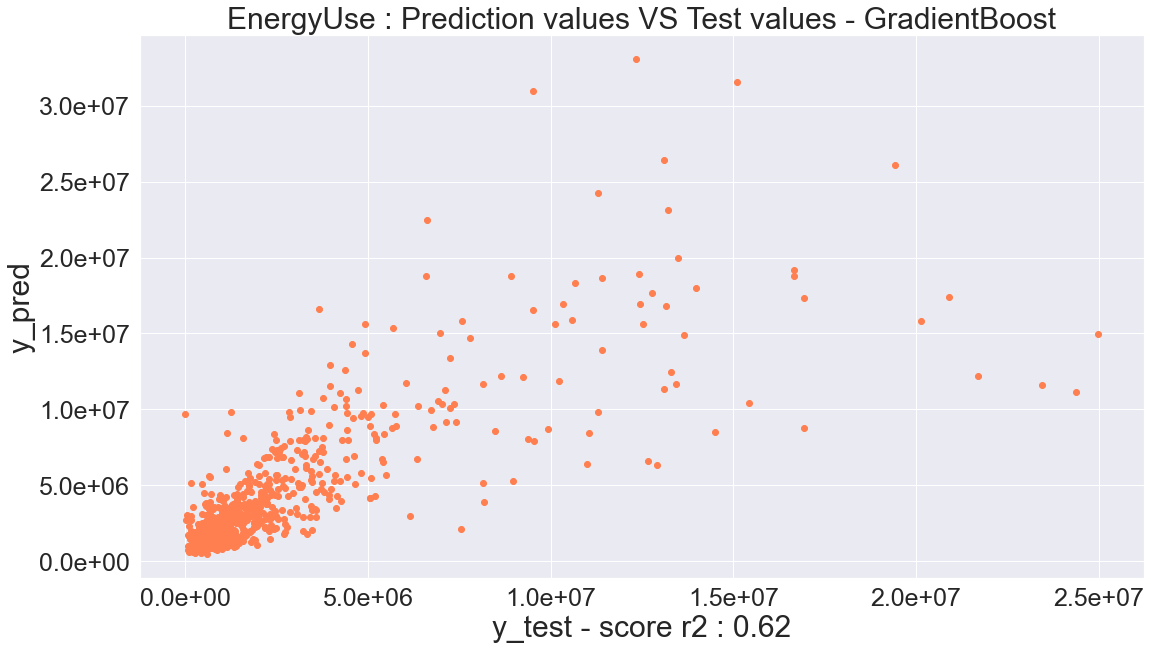

In [128]:
# Split in train-test data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, random_state=100, test_size=0.3)
 
for model in models_list.items():
    # Fit train data with estimator
    model_fit = model[1].fit(X_train, y_train.values.ravel())
        
    # Predict on test data
    y_pred = model_fit.predict(X_test) 
    score = indirect('r2', y_test, y_pred)
    
    # Plot predicted data according to test data 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
    plt.scatter(y_test, y_pred, color='coral')
    plt.xlabel("y_test - score r2 : "+"{0:.2f}".format(score), fontsize=30)
    plt.ylabel("y_pred", fontsize=30)
    ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
    ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    ax.set_title('EnergyUse : Prediction values VS Test values - '+model[0], fontsize=30)
    plt.show()

regression model : Ridge
Ridge(alpha=1000.0)  r2: error_test 0.7106784199019741
Ridge(alpha=1000.0)  r2: error_mean 0.5424448813369007
regression model : Lasso
Lasso(alpha=1000000.0)  r2: error_test 0.4634139514494737
Lasso(alpha=1000000.0)  r2: error_mean 0.4610165504684769
regression model : ElasticNet
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.6081710326416029
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.5461635005836288
regression model : SVR


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_test 0.636480582030506
SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_mean 0.5312936770086658
regression model : LinearSVR
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_test 0.5486907487448875
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_mean 0.5787214143144036
regression model : KernelRidge
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_test 0.6591182901494181
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_mean 0.6135832082326587
regression model : Bagging
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  r2: error_test 0.6108939325030195
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  r2: error_mean 0.5876094828728193
regression model : RandomForest
RandomForestRegressor(ccp_alpha=1, max_depth=1000, max_features='sqrt',
    

0

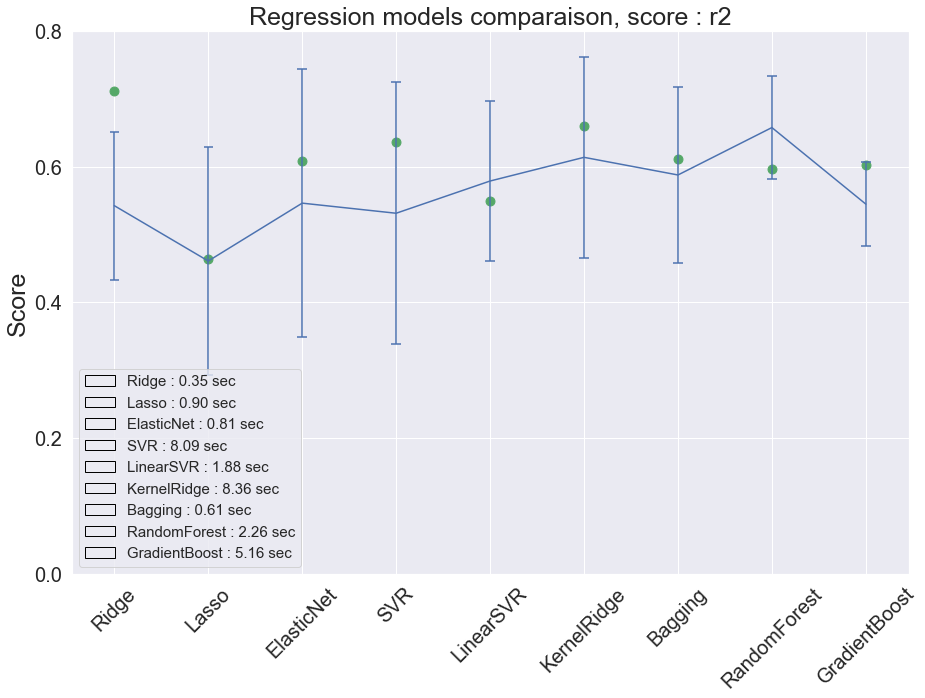

In [130]:
from time import process_time

# Create dataframe to save process time of each regression model
time_df = pd.DataFrame()

# Create subset number
subset_number = 10
# Choose score type
score_type = 'r2'

# Create dataframe that collect score and std score for each regression model
global_scores = pd.DataFrame()

for model in models_list.items():
    t_start = process_time()
    print('regression model :', model[0])
    score_df = apply_cv(model[1], score_type, model[0], subset_number, score_type, X_std,  y)
    global_scores = pd.concat([global_scores, score_df], ignore_index=True)
    t_stop = process_time()
    time_df.loc[0,model[0]] = t_stop-t_start

# Plot results
ax = visualize_scores_mean(global_scores, 
                           "Regression models comparaison, score : "+score_type,
                           _with_test_score=True)

# Add process time for each regression model
legend_text = ["{0} : {1:.2f} sec".format(model, time) 
                for model, time in zip(time_df.columns, time_df.loc[0])]
patches = [Patch(label=text, fill=False, color='black') for text in legend_text]
ax.legend(handles=patches, fontsize=15)

os.system("printf '\7'")

## Scores comparaison

In [131]:
from sklearn.preprocessing import StandardScaler

# Get X
X = data_2015_cut[q_col+list(new_col_2015)]
std_scale = StandardScaler().fit(X)
X_std = std_scale.transform(X)

# Get y
y = data_2015_cut['SiteEnergyUseWN(kBtu)']

score type : explained_variance
Ridge(alpha=1000.0)  explained_variance: error_test 0.5852611316150145
Ridge(alpha=1000.0)  explained_variance: error_mean 0.5684972735688382
Lasso(alpha=1000000.0)  explained_variance: error_test 0.5567149062272528
Lasso(alpha=1000000.0)  explained_variance: error_mean 0.444007484021313
ElasticNet(alpha=1, l1_ratio=0.4)  explained_variance: error_test 0.5535817089920498
ElasticNet(alpha=1, l1_ratio=0.4)  explained_variance: error_mean 0.6167965784061568


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVR(C=20000.0, kernel='linear', max_iter=10000)  explained_variance: error_test 0.5735825051050836
SVR(C=20000.0, kernel='linear', max_iter=10000)  explained_variance: error_mean 0.6312918315121056
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  explained_variance: error_test 0.6636796088838021
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  explained_variance: error_mean 0.5314785693360864
KernelRidge(alpha=2, degree=2, kernel='poly')  explained_variance: error_test 0.4774504151611164
KernelRidge(alpha=2, degree=2, kernel='poly')  explained_variance: error_mean 0.6698296737119644
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  explained_variance: error_test 0.5944272238992461
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  explained_variance: error_mean 0.5999849171329551
RandomForestRegressor(ccp_alpha=1, max_depth=1000, max_features='s

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVR(C=20000.0, kernel='linear', max_iter=10000)  max_error: error_test 34249089.89551495
SVR(C=20000.0, kernel='linear', max_iter=10000)  max_error: error_mean -31746889.622825604
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  max_error: error_test 58579473.97446368
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  max_error: error_mean -31239617.856401615
KernelRidge(alpha=2, degree=2, kernel='poly')  max_error: error_test 60854314.71267697
KernelRidge(alpha=2, degree=2, kernel='poly')  max_error: error_mean -26651839.690626092
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  max_error: error_test 42396773.28676749
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  max_error: error_mean -32418027.15299981
RandomForestRegressor(ccp_alpha=1, max_depth=1000, max_features='sqrt',
                      max_samples=0.99, min_samples_leaf=0.001,
   

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVR(C=20000.0, kernel='linear', max_iter=10000)  neg_mean_absolute_error: error_test 1770089.3728575357
SVR(C=20000.0, kernel='linear', max_iter=10000)  neg_mean_absolute_error: error_mean -1634576.3445018004
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  neg_mean_absolute_error: error_test 1929541.5951762625
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  neg_mean_absolute_error: error_mean -1922965.4851706228
KernelRidge(alpha=2, degree=2, kernel='poly')  neg_mean_absolute_error: error_test 1648330.0719996511
KernelRidge(alpha=2, degree=2, kernel='poly')  neg_mean_absolute_error: error_mean -1721265.0905369725
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  neg_mean_absolute_error: error_test 1753878.9246108884
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  neg_mean_absolute_error: error_mean -1805789.9135079645
RandomForestRegressor(

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVR(C=20000.0, kernel='linear', max_iter=10000)  neg_mean_squared_error: error_test 15843666236187.945
SVR(C=20000.0, kernel='linear', max_iter=10000)  neg_mean_squared_error: error_mean -14292009918966.2
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  neg_mean_squared_error: error_test 14432338331894.807
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  neg_mean_squared_error: error_mean -16800146889816.947
KernelRidge(alpha=2, degree=2, kernel='poly')  neg_mean_squared_error: error_test 17228650777376.729
KernelRidge(alpha=2, degree=2, kernel='poly')  neg_mean_squared_error: error_mean -12892941869192.428
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  neg_mean_squared_error: error_test 19832692736576.918
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  neg_mean_squared_error: error_mean -11710920699258.297
RandomForestRegressor(ccp_alpha=

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVR(C=20000.0, kernel='linear', max_iter=10000)  neg_median_absolute_error: error_test 570921.4681897641
SVR(C=20000.0, kernel='linear', max_iter=10000)  neg_median_absolute_error: error_mean -593908.702591762
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  neg_median_absolute_error: error_test 886234.2478618815
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  neg_median_absolute_error: error_mean -932788.1693838611
KernelRidge(alpha=2, degree=2, kernel='poly')  neg_median_absolute_error: error_test 640962.1417310946
KernelRidge(alpha=2, degree=2, kernel='poly')  neg_median_absolute_error: error_mean -698741.4722936761
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  neg_median_absolute_error: error_test 821814.8898084277
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  neg_median_absolute_error: error_mean -791523.6001928991
RandomForestReg

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_test 0.5808009156455909
SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_mean 0.5013991648681972
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_test 0.6412762510188152
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_mean 0.4964052654836598
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_test 0.7329260815344737
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_mean 0.5962596165333064
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  r2: error_test 0.6209027141621118
BaggingRegressor(base_estimator=Ridge(alpha=1000.0), n_estimators=100,
                 n_jobs=-1)  r2: error_mean 0.5794106608132749
RandomForestRegressor(ccp_alpha=1, max_depth=1000, max_features='sqrt',
                      max_samples=0.99, min_samples_leaf=0.001,
                      min_samples_split=0.0001, min_weight

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/3103065735.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df['score_mean'] =(scores_df['score_mean']-scores_df['score_mean'].min())/\


0

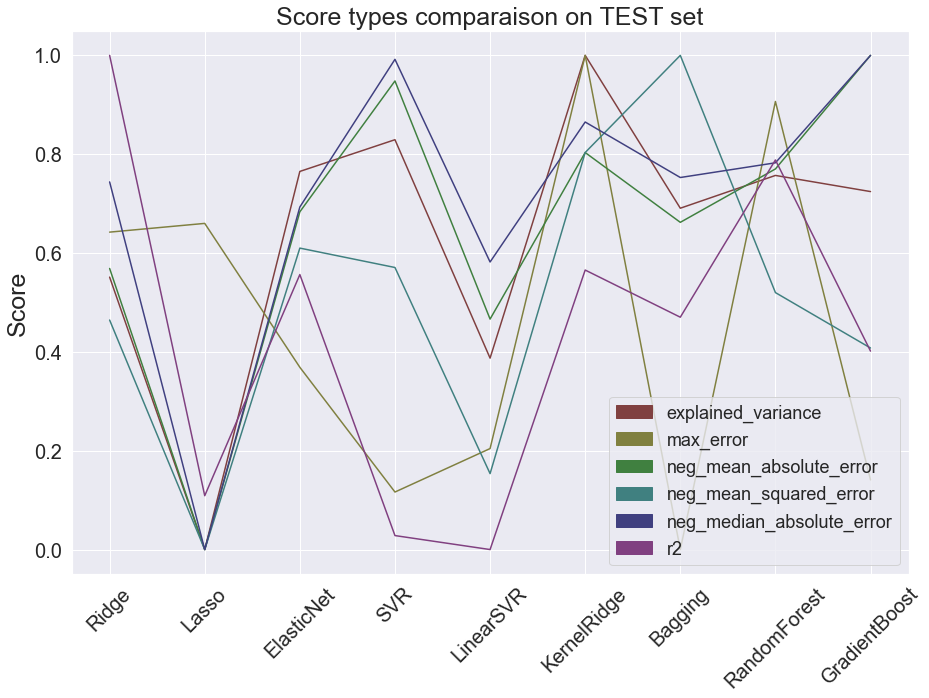

In [133]:
# Create subset number
subset_number = 10
# Choose score type
score_types = [
               'explained_variance',
               'max_error',
               'neg_mean_absolute_error',
               'neg_mean_squared_error',
               'neg_median_absolute_error',
               'r2',
              ]

# Create dataframe that collect score and std score for current regression model
global_scores = pd.DataFrame()

# Process regression on data for each model and for each score
for score_type in score_types:
    print('score type :', score_type)
    for model in models_list.items():
        score_df = apply_cv(model[1], score_type, model[0], subset_number, score_type, X_std,  y)
        global_scores = pd.concat([global_scores, score_df], ignore_index=True) 
    
#with pd.option_context('display.float_format', '{:.2f}'.format):
#    print(global_scores)

scores_list = [global_scores[global_scores['curve'] == score] for score in score_types]

scores_list_tp = scores_list
global_scores_uni = pd.DataFrame()
for scores_df in scores_list_tp:
    scores_df['score_mean'] =(scores_df['score_mean']-scores_df['score_mean'].min())/\
                             (scores_df['score_mean'].max()-scores_df['score_mean'].min())
    global_scores_uni = pd.concat([global_scores_uni, scores_df], ignore_index=True)
    
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))

curves = list(global_scores_uni['curve'].unique())
curve_colors = get_colors(len(curves))
    
patches=[]
for curve, color in zip(curves, curve_colors):
    curve_df = global_scores_uni[global_scores_uni['curve'] == curve]
    plt.plot(curve_df['x_axis'], curve_df['score_mean'], color=color)
    patches.append(Patch(label=curve, fill=True, color=color))
    
ax.legend(handles=patches, fontsize=18)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20,rotation=0)

plt.ylabel('Score', fontsize=25)
    
# Add title
plt.title("Score types comparaison on TEST set", fontsize=25)
    
os.system("printf '\7'")

## Energy global VS Energy Building

In [134]:
from sklearn.preprocessing import StandardScaler

# Get X
X = data_2015_cut[q_col+list(new_col_2015)]
std_scale = StandardScaler().fit(X)
X_std = std_scale.transform(X)

# Get y
y_energy_gl = data_2015_cut['SiteEnergyUseWN(kBtu)']
y_energy_bg = data_2015_cut['SiteEnergyUse(kBtu)']

regression model : Ridge
Ridge(alpha=1000.0)  r2: error_test 0.5521360609331674
Ridge(alpha=1000.0)  r2: error_mean 0.6164095940082693
Ridge(alpha=1000.0)  r2: error_test 0.6856093723403316
Ridge(alpha=1000.0)  r2: error_mean 0.6596036121914665
regression model : Lasso
Lasso(alpha=1000000.0)  r2: error_test 0.5248146934013287
Lasso(alpha=1000000.0)  r2: error_mean 0.474916964746437
Lasso(alpha=1000000.0)  r2: error_test 0.6238722280607443
Lasso(alpha=1000000.0)  r2: error_mean 0.5673017836715051
regression model : ElasticNet
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.6425429350574395
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.5653237579556555
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.701708547542058
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.6647901606623365
regression model : LinearSVR
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_test 0.6321272022830337
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_inse

0

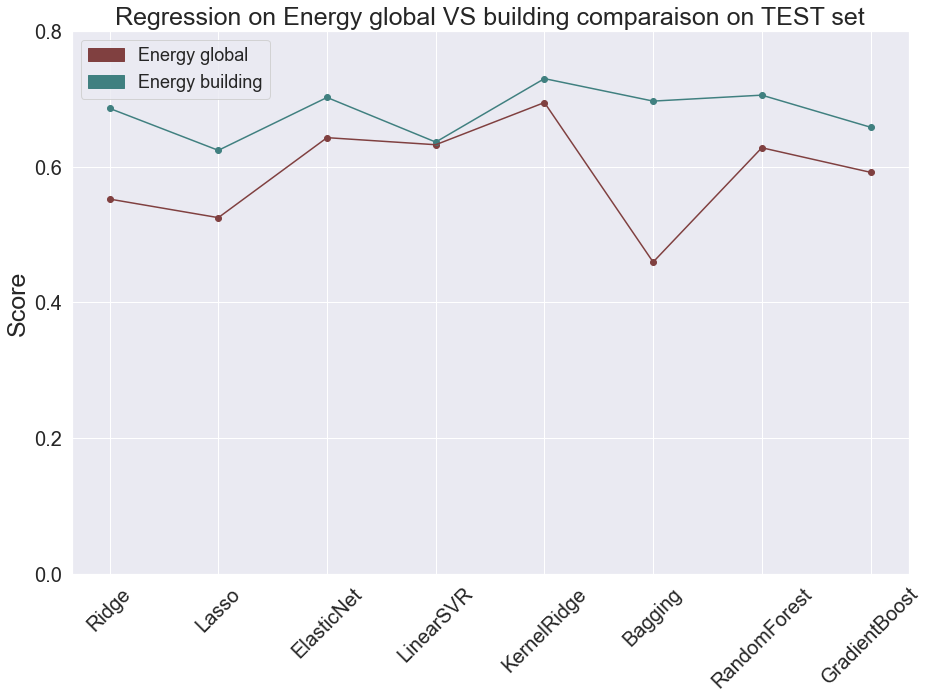

In [135]:
# Create subset number
subset_number = 10
# Choose score type
score_type = 'r2'

# Create dataframe that collect score and std score for each regression model
global_scores = pd.DataFrame()

for model in models_list.items():
    if model[0] == 'SVR':
        continue
    print('regression model :', model[0])
    score_df = apply_cv(model[1], 'Energy global', model[0], subset_number, score_type, X_std,  y_energy_gl)
    global_scores = pd.concat([global_scores, score_df], ignore_index=True)
    score_df = apply_cv(model[1], 'Energy building', model[0], subset_number, score_type, X_std,  y_energy_bg)
    global_scores = pd.concat([global_scores, score_df], ignore_index=True) 

# Plot results
ax = visualize_test_scores(global_scores, 
                     "Regression on Energy global VS building comparaison on TEST set")

os.system("printf '\7'")

## Energy VS Emissions

In [136]:
from sklearn.preprocessing import StandardScaler

# Get X
X = data_2015_cut[q_col+list(new_col_2015)]
std_scale = StandardScaler().fit(X)
X_std = std_scale.transform(X)

# Get y
y_energy = data_2015_cut['SiteEnergyUseWN(kBtu)']
y_CO = data_2015_cut['TotalGHGEmissions(MetricTonsCO2e)']

regression model : Ridge
Ridge(alpha=1000.0)  r2: error_test 0.6021493449668847
Ridge(alpha=1000.0)  r2: error_mean 0.6143642014764616
Ridge(alpha=1000.0)  r2: error_test 0.4436539568500981
Ridge(alpha=1000.0)  r2: error_mean 0.3555750281882256
regression model : Lasso
Lasso(alpha=1000000.0)  r2: error_test 0.4295029205381723
Lasso(alpha=1000000.0)  r2: error_mean 0.5516677738070037
Lasso(alpha=1000000.0)  r2: error_test -0.003401164421425351
Lasso(alpha=1000000.0)  r2: error_mean -0.0038368197741338373
regression model : ElasticNet
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.6416256743039348
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.5539432541928792
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.4535989165496225
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.33720756866213686
regression model : LinearSVR
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_test 0.48703407612729355
LinearSVR(C=0.001, epsilon=100.0, loss='squared_e

0

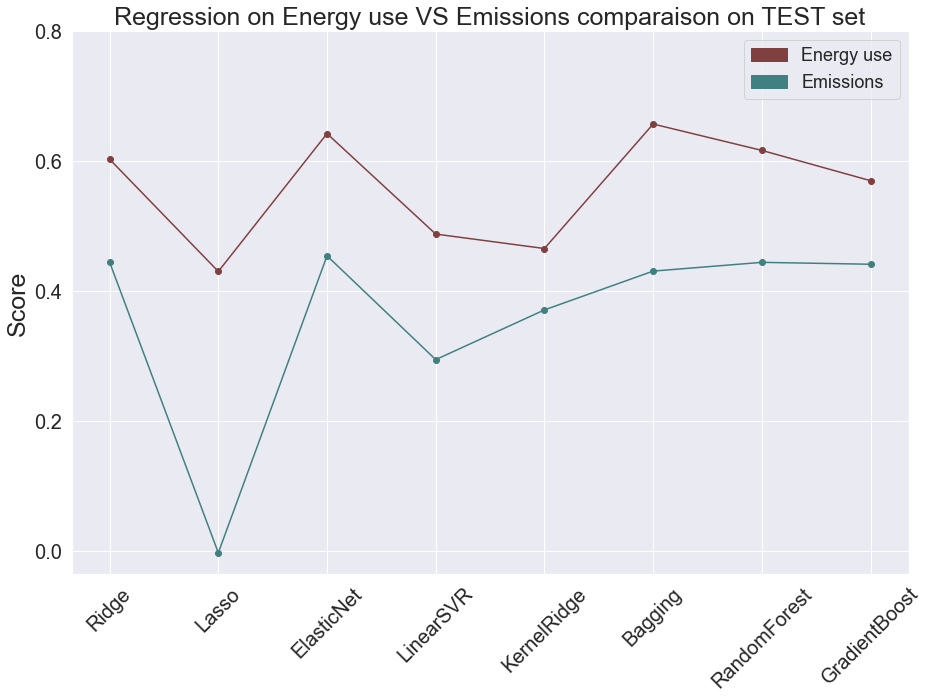

In [137]:
# Create subset number
subset_number = 10
# Choose score type
score_type = 'r2'

# Create dataframe that collect score and std score for each regression model
global_scores = pd.DataFrame()

for model in models_list.items():
    if model[0] == 'SVR':
        continue
    print('regression model :', model[0])
    score_df = apply_cv(model[1], 'Energy use', model[0], subset_number, score_type, X_std,  y_energy)
    global_scores = pd.concat([global_scores, score_df], ignore_index=True)
    score_df = apply_cv(model[1], 'Emissions', model[0], subset_number, score_type, X_std,  y_CO)
    global_scores = pd.concat([global_scores, score_df], ignore_index=True) 

# Plot results
ax = visualize_test_scores(global_scores, 
                     "Regression on Energy use VS Emissions comparaison on TEST set")

os.system("printf '\7'")

## With VS without ENERGYSTARScore

In [138]:
from sklearn.preprocessing import StandardScaler

# Get X without ENERGYSTARScore
X = data_2015_cut[q_col+list(new_col_2015)]
std_scale = StandardScaler().fit(X)
X_std = std_scale.transform(X)

# Get X with ENERGYSTARScore
X_ES = data_2015_cut[q_col+['ENERGYSTARScore']+list(new_col_2015)]
# Select only row that have ENERGYSTARScore value filled
X_ES = X_ES[~np.isnan(X_ES['ENERGYSTARScore'])]

std_scale = StandardScaler().fit(X_ES)
X_ES_std = std_scale.transform(X_ES)

# Create y
y = data_2015_cut['SiteEnergyUseWN(kBtu)']
y_ES = data_2015_cut[~np.isnan(data_2015_cut['ENERGYSTARScore'])]['SiteEnergyUseWN(kBtu)']

regression model : Ridge
Ridge(alpha=1000.0)  r2: error_test 0.5787552394868263
Ridge(alpha=1000.0)  r2: error_mean 0.5978934344210124
Ridge(alpha=1000.0)  r2: error_test 0.5834495058148754
Ridge(alpha=1000.0)  r2: error_mean 0.6812915526381984
regression model : Lasso
Lasso(alpha=1000000.0)  r2: error_test 0.43525177689494465
Lasso(alpha=1000000.0)  r2: error_mean 0.5197234576185786
Lasso(alpha=1000000.0)  r2: error_test 0.5817343512363042
Lasso(alpha=1000000.0)  r2: error_mean 0.5602454261209255
regression model : ElasticNet
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.5968351536611587
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.5968123796581482
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.709128058607633
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.6501710627269389
regression model : SVR


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_test 0.5007655182279225
SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_mean 0.5600022720961257


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_test 0.6099820247725586
SVR(C=20000.0, kernel='linear', max_iter=10000)  r2: error_mean 0.684385219032609
regression model : LinearSVR
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_test 0.5483847136223037
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_mean 0.5494380797623909
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_test 0.5515264296416473
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_mean 0.6698821734379685
regression model : KernelRidge
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_test 0.6407175182349996
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_mean 0.5733597223134771
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_test 0.7754345795911017
KernelRidge(alpha=2, degree=2, kernel='poly')  r2: error_mean 0.5298428322813908
regression model : Bagging
Bagg

0

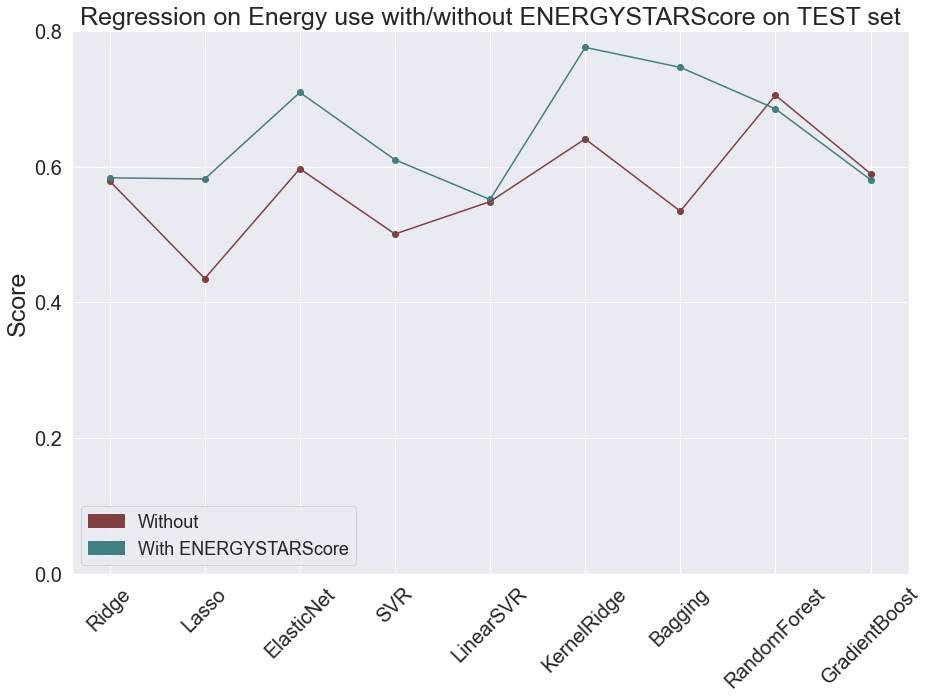

In [139]:
# Create subset number
subset_number = 10
# Choose score type
score_type = 'r2'

# Create dataframe that collect score and std score for each regression model
global_scores = pd.DataFrame()

for model in models_list.items():
    print('regression model :', model[0])
    score_df = apply_cv(model[1], 'Without', model[0], subset_number, score_type, X_std,  y)
    global_scores = pd.concat([global_scores, score_df], ignore_index=True)
    score_df = apply_cv(model[1], 'With ENERGYSTARScore', model[0], subset_number, score_type, X_ES_std,  y_ES)
    global_scores = pd.concat([global_scores, score_df], ignore_index=True) 
    
# Plot results
ax = visualize_test_scores(global_scores, 
                     "Regression on Energy use with/without ENERGYSTARScore on TEST set")

os.system("printf '\7'")

In [140]:
from sklearn.preprocessing import StandardScaler

# Get X without ENERGYSTARScore
X = data_2015_cut[q_col+list(new_col_2015)]
std_scale = StandardScaler().fit(X)
X_std = std_scale.transform(X)

# Get X with ENERGYSTARScore
X_ES = data_2015_cut[q_col+['ENERGYSTARScore']+list(new_col_2015)]
# Select only row that have ENERGYSTARScore value filled
X_ES = X_ES[~np.isnan(X_ES['ENERGYSTARScore'])]

std_scale = StandardScaler().fit(X_ES)
X_ES_std = std_scale.transform(X_ES)

# Create y
y = data_2015_cut['TotalGHGEmissions(MetricTonsCO2e)']
y_ES = data_2015_cut[~np.isnan(data_2015_cut['ENERGYSTARScore'])]['TotalGHGEmissions(MetricTonsCO2e)']

regression model : Ridge
Ridge(alpha=1000.0)  r2: error_test 0.36361487652966207
Ridge(alpha=1000.0)  r2: error_mean 0.40463418554583175
Ridge(alpha=1000.0)  r2: error_test 0.4788062760573828
Ridge(alpha=1000.0)  r2: error_mean 0.4552808510782114
regression model : Lasso
Lasso(alpha=1000000.0)  r2: error_test -5.275689582595611e-05
Lasso(alpha=1000000.0)  r2: error_mean -0.0053237932508598765
Lasso(alpha=1000000.0)  r2: error_test -0.004314277152367874
Lasso(alpha=1000000.0)  r2: error_mean -0.003829519783328683
regression model : ElasticNet
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.4058958935756528
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.36065057265023526
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_test 0.4737147532884508
ElasticNet(alpha=1, l1_ratio=0.4)  r2: error_mean 0.44197473233979634
regression model : LinearSVR
LinearSVR(C=0.001, epsilon=100.0, loss='squared_epsilon_insensitive')  r2: error_test 0.18974426832430114
LinearSVR(C=0.001, epsilon=100.0, loss=

0

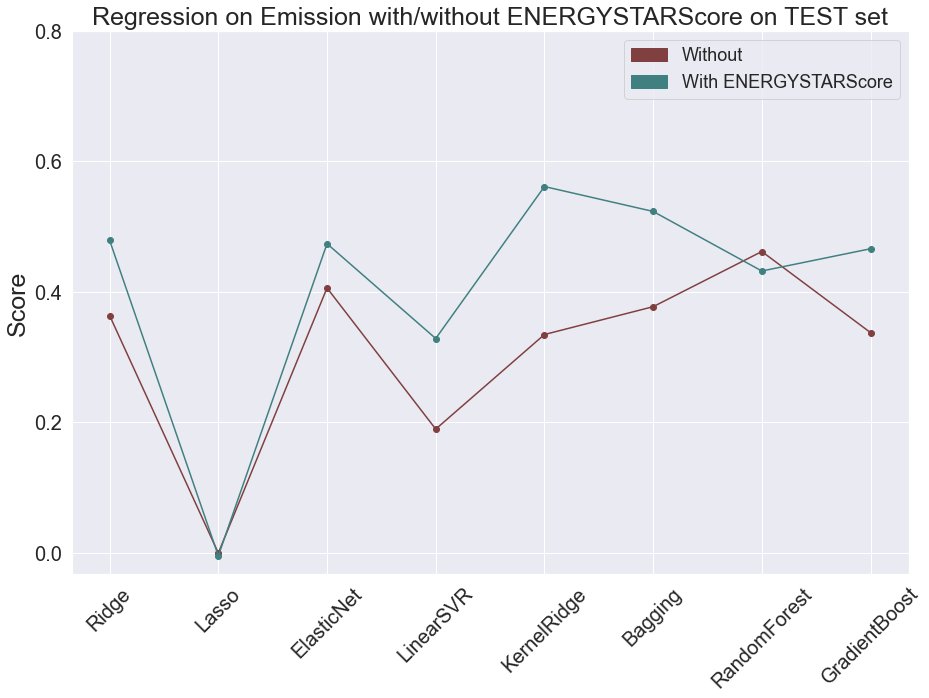

In [141]:
# Create subset number
subset_number = 10
# Choose score type
score_type = 'r2'

# Create dataframe that collect score and std score for each regression model
global_scores = pd.DataFrame()

for model in models_list.items():
    if model[0] == 'SVR':
        continue
    print('regression model :', model[0])
    score_df = apply_cv(model[1], 'Without', model[0], subset_number, score_type, X_std,  y)
    global_scores = pd.concat([global_scores, score_df], ignore_index=True)
    score_df = apply_cv(model[1], 'With ENERGYSTARScore', model[0], subset_number, score_type, X_ES_std,  y_ES)
    global_scores = pd.concat([global_scores, score_df], ignore_index=True) 
    
# Plot results
ax = visualize_test_scores(global_scores, 
                     "Regression on Emission with/without ENERGYSTARScore on TEST set")

os.system("printf '\7'")

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1792682719.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1152/1792682719.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])


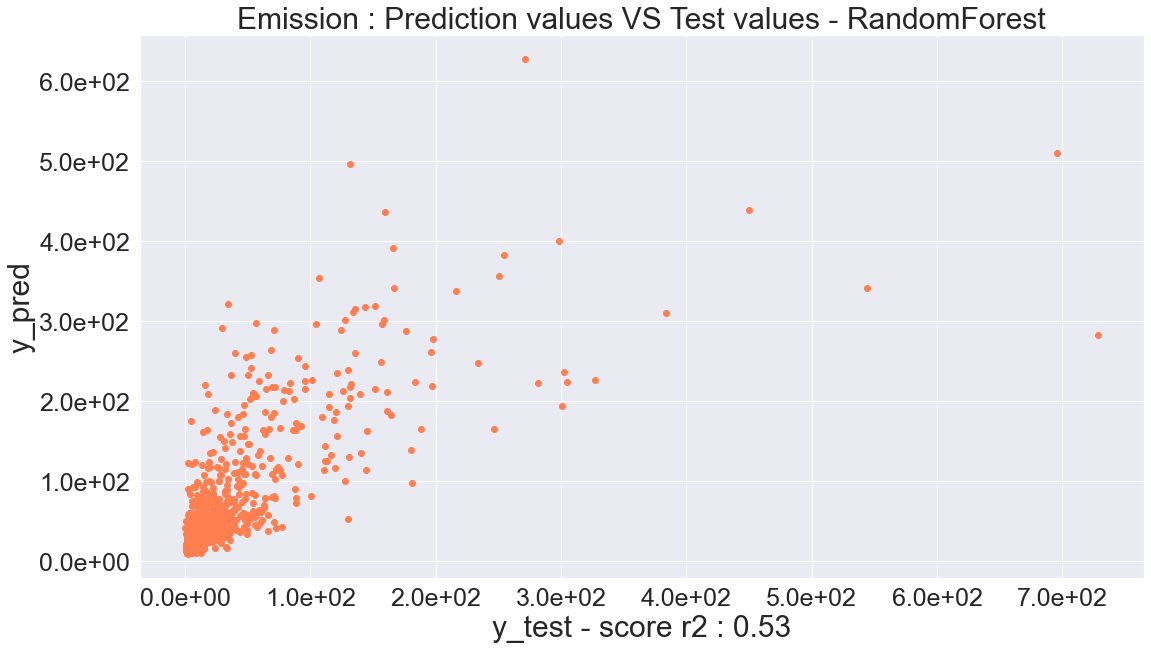

In [142]:
# Split in train-test data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_ES_std, y_ES, random_state=100, test_size=0.3)

# Fit train data with estimator
rf_fit = randomForest_model.fit(X_train, y_train.values.ravel())
        
# Predict on test data
y_pred = rf_fit.predict(X_test) 
score = indirect('r2', y_test, y_pred)
    
# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test - score r2 : "+"{0:.2f}".format(score), fontsize=30)
plt.ylabel("y_pred", fontsize=30)
ax.set_xticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
ax.set_yticklabels(['{:.1e}'.format(x) for x in ax.get_yticks()])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.set_title('Emission : Prediction values VS Test values - RandomForest', fontsize=30)
plt.show()